In [1]:
import numpy as np
import matplotlib.pyplot as plt
from clearml.backend_api.session.client import APIClient
from tqdm import tqdm
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
LOSS_FUNS = ["CE", "N", "B", "U"]
ARCHITECTURES = ["CNN", "ResNet50"]
NOISE_TYPES = [
    "clean_label",
    "worse_label",
]
SEEDS = [42, 0, 17, 9, 3, 16, 2]
COLORS = [
    "lightcoral",
    "indianred",
    "brown",
    "firebrick",
    "maroon",
    "darkred",
    "tomato",
]
BASE_COLOR = "red"
LS = 0.0
LOSS_MAPS = {
    "CE": "Cross Entropy",
    "N": "N-Loss",
    "B": "B-Loss",
    "U": "UCA-Loss",
}
NOISE_MAPS = {
    "clean_label": "clean labels",
    "worse_label": "worse labels",
}

Reading data: 100%|██████████| 7/7 [00:10<00:00,  1.50s/it]


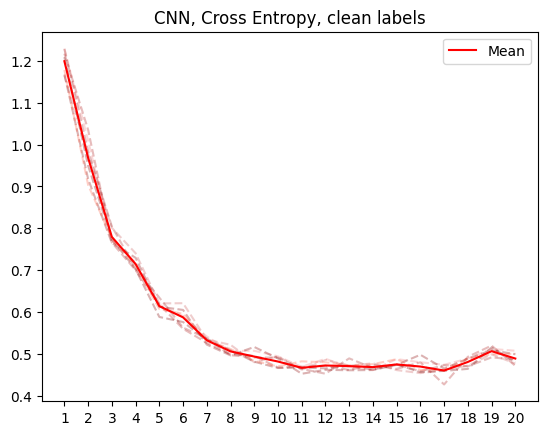

Reading data: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


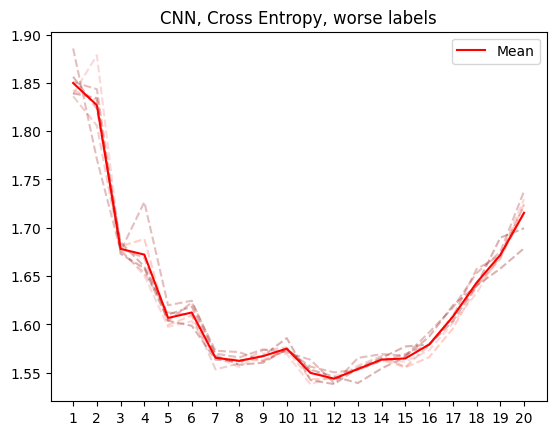

Reading data: 100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


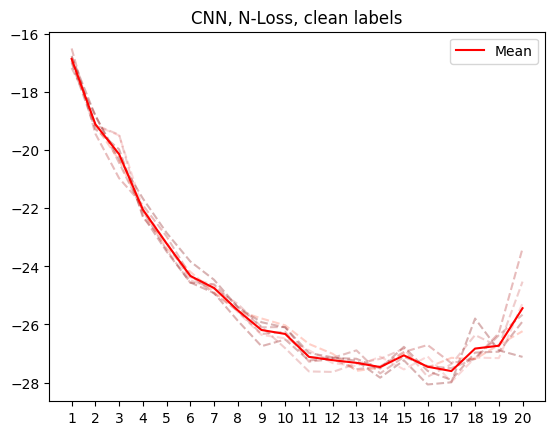

Reading data: 100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


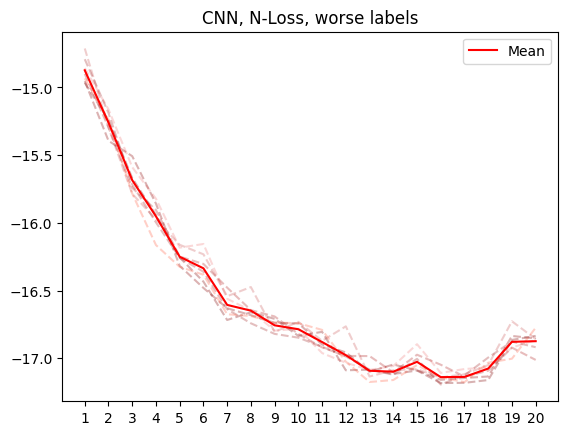

Reading data: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


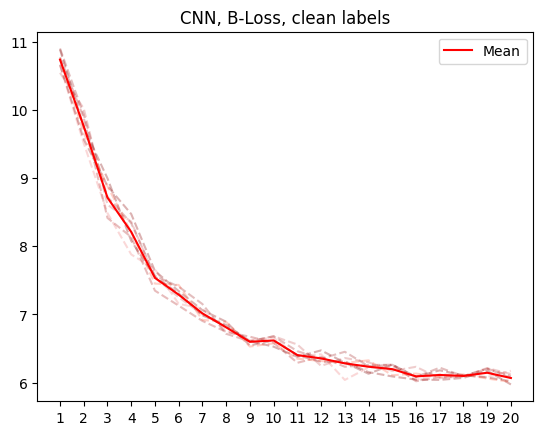

Reading data: 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


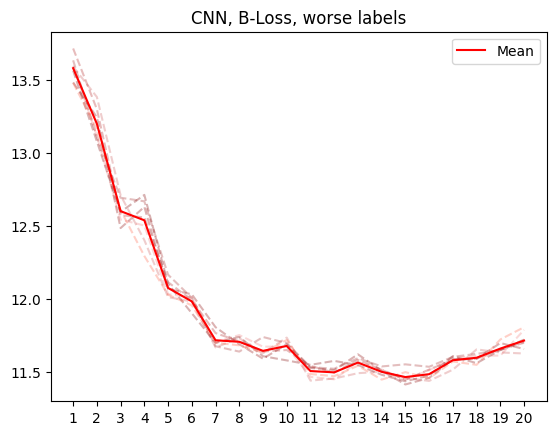

Reading data: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


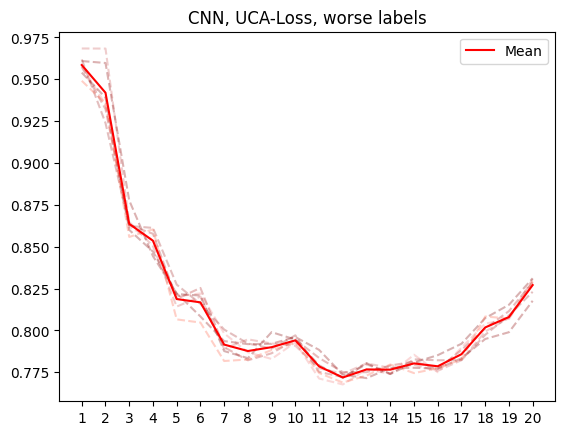

Reading data: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


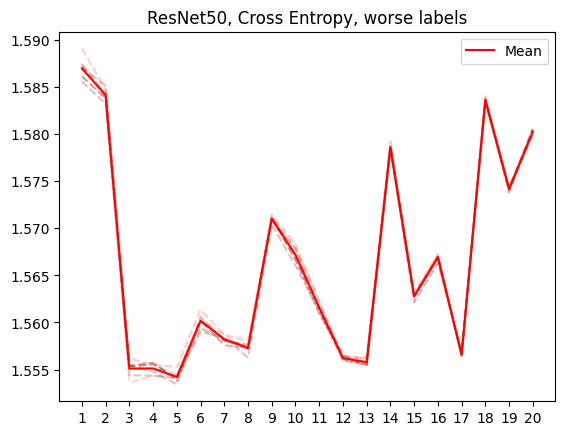

Reading data: 100%|██████████| 7/7 [00:10<00:00,  1.55s/it]


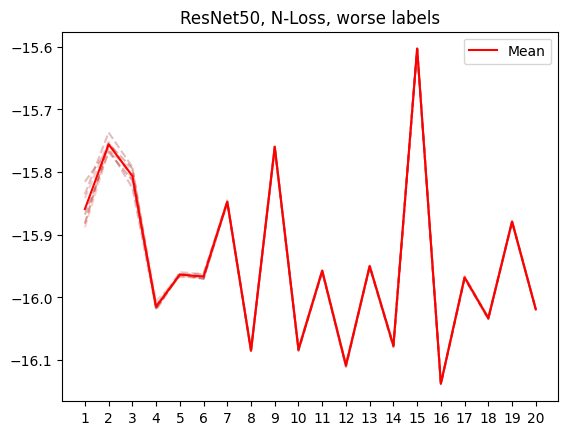

Reading data: 100%|██████████| 7/7 [00:10<00:00,  1.56s/it]


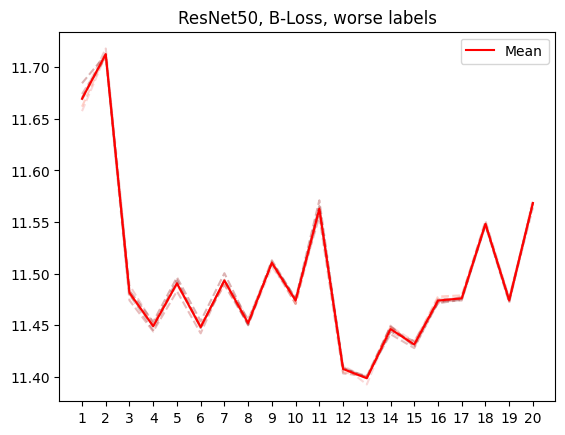

In [4]:
client = APIClient()

for arch in ARCHITECTURES:
    for loss_name in LOSS_FUNS:
        for noise_type in NOISE_TYPES:
            if arch == "ResNet50" and loss_name == "U":
                continue
            if arch == "ResNet50" and noise_type == "clean_label":
                continue
            if loss_name == "U" and noise_type == "clean_label":
                continue

            epochs = [i for i in range(1, 21)]
            val_losses = []
            bar = tqdm(zip(COLORS, SEEDS), total=len(COLORS), desc="Reading data")

            plt.title(f"{arch}, {LOSS_MAPS[loss_name]}, {NOISE_MAPS[noise_type]}")
            for c, seed in bar:
                task_name=f"arch_{arch}_loss_{loss_name}_seed_{seed}_LS_{LS}_noise_{noise_type}"
                tasks = client.tasks.get_all(name=task_name, status=["completed"])
                assert len(tasks) == 1, f"{task_name}, len(tasks)={len(tasks)}"
                task_id = tasks[0].id
                cur_losses = client.events.scalar_metrics_iter_histogram(task=task_id).metrics["val_loss_epoch"]["val_loss_epoch"]["y"]
                val_losses.append(cur_losses)
                plt.plot(epochs, cur_losses, "--", color=c, alpha=0.3)
            val_losses = np.array(val_losses).mean(axis=0)
            plt.plot(epochs, val_losses, color=BASE_COLOR, label="Mean")
            plt.xticks(epochs)
            plt.legend(loc="best")
            plt.savefig(f"arch_{arch}_loss_{loss_name}_LS_{LS}_noise_{noise_type}.png")
            plt.show()

In [7]:
for arch in ARCHITECTURES:
    for loss_name in LOSS_FUNS:
        for noise_type in NOISE_TYPES:
            if arch == "ResNet50" and loss_name == "U":
                continue
            if arch == "ResNet50" and noise_type == "clean_label":
                continue
            if loss_name == "U" and noise_type == "clean_label":
                continue

            bar = tqdm(SEEDS, total=len(COLORS), desc="Reading data")
            tasks_ids = []
            for seed in bar:
                task_name=f"arch_{arch}_loss_{loss_name}_seed_{seed}_LS_{LS}_noise_{noise_type}"
                tasks = client.tasks.get_all(name=task_name, status=["completed"])
                assert len(tasks) == 1, f"{task_name}, len(tasks)={len(tasks)}"
                tasks_ids.append(tasks[0].id)
            
            hyperparams = [
                cfg["hyperparams"]
                for cfg in client.tasks.get_hyper_params(tasks=tasks_ids).params
                if [p for p in cfg.get("hyperparams", []) if p.get("name", "") == "Mean Accuracy (individual)"]
            ][0]
            emv_value = [
                float(hp["value"])
                for hp in hyperparams
                if hp["name"] == "Ensemble Accuracy (EMV)"
            ][0] * 100
            ewp_value = [
                float(hp["value"])
                for hp in hyperparams
                if hp["name"] == "Ensemble Accuracy (EWP)"
            ][0] * 100
            mean_acc = [
                float(hp["value"])
                for hp in hyperparams
                if hp["name"] == "Mean Accuracy (individual)"
            ][0] * 100
            std_acc = [
                float(hp["value"])
                for hp in hyperparams
                if hp["name"] == "Standard Deviation of Accuracy (individual)"
            ][0] * 100
            print(arch, LOSS_MAPS[loss_name], NOISE_MAPS[noise_type])
            print(
                f"${mean_acc:.2f}\\pm{std_acc:.3f} / {{{emv_value:.2f}}} / {{{ewp_value:.2f}}}$"
            )

Reading data:   0%|          | 0/7 [00:00<?, ?it/s]

Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


CNN Cross Entropy clean labels
$84.46\pm0.603 / {88.24} / {88.44}$


Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


CNN Cross Entropy worse labels
$71.53\pm0.525 / {75.11} / {75.38}$


Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


CNN N-Loss clean labels
$85.93\pm0.685 / {88.97} / {89.02}$


Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


CNN N-Loss worse labels
$73.08\pm0.416 / {76.42} / {76.67}$


Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


CNN B-Loss clean labels
$84.15\pm0.407 / {87.90} / {87.90}$


Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


CNN B-Loss worse labels
$72.68\pm0.435 / {76.38} / {76.67}$


Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


CNN UCA-Loss worse labels
$71.48\pm0.518 / {74.86} / {74.74}$


Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


ResNet50 Cross Entropy worse labels
$72.40\pm0.371 / {72.47} / {69.49}$


Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


ResNet50 N-Loss worse labels
$72.44\pm0.015 / {72.46} / {72.46}$


Reading data: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


ResNet50 B-Loss worse labels
$74.48\pm0.060 / {74.50} / {74.50}$
